<a href="https://colab.research.google.com/github/gpasxos/large-scale-optimization/blob/main/ch06_interior_point_method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Barrier Gradient and Hessian

For centering via Newton, we need:
$$\nabla \phi(x) = -\sum_{i=1}^m \frac{\nabla g_i(x)}{g_i(x)}, \qquad \nabla^2 \phi(x) = \sum_{i=1}^m \frac{\nabla g_i(x) \nabla g_i(x)^T}{g_i(x)^2} - \sum_{i=1}^m \frac{\nabla^2 g_i(x)}{g_i(x)}$$

## Line Search with Feasibility

The backtracking line search must ensure $g_i(x + \eta \Delta x) < 0$ for all $i$. We first find the maximum feasible step, then backtrack for sufficient decrease.

## Demo Problem

We solve a **quadratic program**:
$$\min_x \frac{1}{2}x^T Q x + c^T x \quad \text{s.t.} \quad Gx \leq h$$

with $n=5$ variables and $m=8$ inequality constraints.

Barrier Method Demo: Quadratic Program
Variables: 5, Inequality constraints: 8
Initial point feasibility: True
Outer 0: t = 1.00e+00, gap = 8.00e+00, f = 0.000000e+00
Outer 1: t = 1.50e+01, gap = 5.33e-01, f = -2.810793e+00
Outer 2: t = 2.25e+02, gap = 3.56e-02, f = -3.945386e+00
Outer 3: t = 3.38e+03, gap = 2.37e-03, f = -4.019150e+00
Outer 4: t = 5.06e+04, gap = 1.58e-04, f = -4.023386e+00
Outer 5: t = 7.59e+05, gap = 1.05e-05, f = -4.023662e+00
Outer 6: t = 1.14e+07, gap = 7.02e-07, f = -4.023681e+00
Outer 7: t = 1.71e+08, gap = 4.68e-08, f = -4.023682e+00
Outer 8: t = 2.56e+09, gap = 3.12e-09, f = -4.023682e+00
Converged: duality gap 3.12e-09 < 1e-08

Optimal value: -4.023682
Constraint satisfaction: [np.float64(-0.3810948367801348), np.float64(-4.584985623533504), np.float64(-5.049841168956159)]...


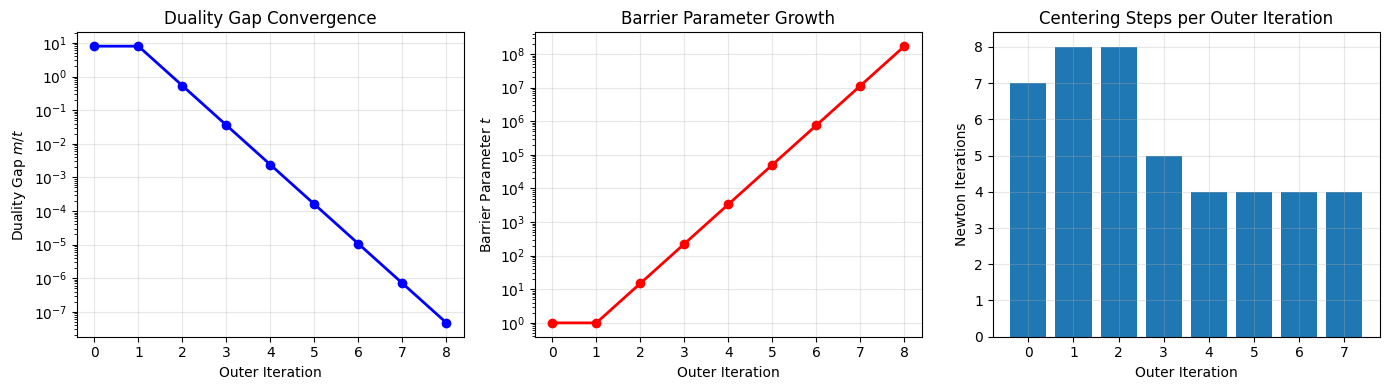

(array([-0.6946766 ,  1.4433774 , -0.52482022,  3.45847365,  1.87193979]),
 {'x': [array([0., 0., 0., 0., 0.]),
   array([-0.82479435,  1.2358693 , -0.36898041,  3.39497466,  1.21577128]),
   array([-0.69994976,  1.40852657, -0.51669991,  3.47293956,  1.78871291]),
   array([-0.69457096,  1.43998291, -0.52436256,  3.4602518 ,  1.86540128]),
   array([-0.6946644 ,  1.44314071, -0.52479009,  3.45859808,  1.87149527]),
   array([-0.69467576,  1.44336157, -0.52481821,  3.45848199,  1.87191011]),
   array([-0.69467654,  1.44337635, -0.52482009,  3.4584742 ,  1.87193782]),
   array([-0.69467659,  1.44337734, -0.52482021,  3.45847368,  1.87193967]),
   array([-0.6946766 ,  1.4433774 , -0.52482022,  3.45847365,  1.87193979])],
  'f': [np.float64(0.0),
   np.float64(-2.810793333987063),
   np.float64(-3.9453863933259337),
   np.float64(-4.01915023525221),
   np.float64(-4.023385512163875),
   np.float64(-4.023662466494714),
   np.float64(-4.023680904549158),
   np.float64(-4.023682133638521),
 

In [3]:
import numpy as np
from scipy.linalg import cho_factor, cho_solve

def barrier_method(f, grad_f, hess_f, g_list, grad_g_list, hess_g_list,
                   A, b, x0, t0=1.0, mu=10.0, tol=1e-8, max_outer=50,
                   max_inner=50, alpha=0.25, beta=0.5, verbose=True):
    """
    Barrier method for inequality-constrained optimization.

    min f(x) s.t. g_i(x) <= 0, i=1,...,m, Ax = b

    Parameters:
        f, grad_f, hess_f: objective and derivatives
        g_list: list of constraint functions g_i(x)
        grad_g_list, hess_g_list: constraint derivatives
        A, b: equality constraint matrix and vector (can be None)
        x0: strictly feasible initial point
        t0: initial barrier parameter
        mu: barrier parameter growth factor (typically 10-20)
        tol: duality gap tolerance
    """
    x = np.array(x0, dtype=float)
    n = len(x)
    m = len(g_list) # Number of inequality constraints
    t = t0

    # Handle equality constraints
    if A is not None:
        p = A.shape[0]
    else:
        p = 0
        A = np.zeros((0, n))
        b = np.zeros(0)

    history = {
        'x': [x.copy()],
        'f': [f(x)],
        't': [t],
        'duality_gap': [m / t],
        'newton_iters': []
    }

    def barrier(x):
        """Logarithmic barrier function."""
        val = 0.0
        for g_i in g_list:
            gi = g_i(x)
            if gi >= 0:
                return np.inf
            val -= np.log(-gi)
        return val

    def barrier_grad(x):
        """Gradient of barrier function."""
        grad = np.zeros(n)
        for g_i, grad_g_i in zip(g_list, grad_g_list):
            gi = g_i(x)
            grad -= grad_g_i(x) / gi
        return grad

    def barrier_hess(x):
        """Hessian of barrier function."""
        H = np.zeros((n, n))
        for g_i, grad_g_i, hess_g_i in zip(g_list, grad_g_list, hess_g_list):
            gi = g_i(x)
            grad_gi = grad_g_i(x)
            H += np.outer(grad_gi, grad_gi) / (gi ** 2)
            H -= hess_g_i(x) / gi
        return H

    for outer in range(max_outer):
        # Check duality gap
        gap = m / t
        if verbose:
            print(f"Outer {outer}: t = {t:.2e}, gap = {gap:.2e}, f = {f(x):.6e}")

        if gap < tol:
            if verbose:
                print(f"Converged: duality gap {gap:.2e} < {tol}")
            break

        # Centering: minimize t*f(x) + phi(x) subject to Ax = b
        # using Newton's method
        newton_iters = 0

        for inner in range(max_inner):
            # Gradient and Hessian of t*f + phi
            g_total = t * grad_f(x) + barrier_grad(x)
            H_total = t * hess_f(x) + barrier_hess(x)

            # Form KKT system
            if p > 0:
                KKT = np.block([
                    [H_total, A.T],
                    [A, np.zeros((p, p))]
                ])
                rhs = np.concatenate([-g_total, np.zeros(p)])
            else:
                KKT = H_total
                rhs = -g_total

            # Solve for Newton step
            try:
                if p > 0:
                    sol = np.linalg.solve(KKT, rhs)
                    dx = sol[:n]
                else:
                    c, lower = cho_factor(KKT)
                    dx = cho_solve((c, lower), rhs)
            except np.linalg.LinAlgError:
                print("Warning: KKT system singular")
                break

            # Newton decrement
            lambda_sq = -g_total @ dx

            if lambda_sq / 2 < 1e-10:
                break

            # Backtracking line search (ensure feasibility)
            eta = 1.0

            # First, find maximum step that maintains feasibility
            for g_i in g_list:
                # Binary search for feasibility
                while eta > 1e-10 and g_i(x + eta * dx) >= 0:
                    eta *= 0.5

            eta *= 0.99 # Stay strictly inside

            # Now backtrack for sufficient decrease
            f_curr = t * f(x) + barrier(x)
            while eta > 1e-16:
                x_new = x + eta * dx
                f_new = t * f(x_new) + barrier(x_new)
                if f_new <= f_curr - alpha * eta * lambda_sq:
                    break
                eta *= beta

            x = x + eta * dx
            newton_iters += 1

        history['x'].append(x.copy())
        history['f'].append(f(x))
        history['t'].append(t)
        history['duality_gap'].append(m / t)
        history['newton_iters'].append(newton_iters)

        # Increase t
        t *= mu

    return x, history

def demo_barrier_method():
    """Demo: quadratic program with inequality constraints."""
    np.random.seed(42)

    # min 0.5 * x'Qx + c'x
    # s.t. Gx <= h

    n = 5
    m = 8 # Number of inequality constraints

    # Objective
    Q = np.eye(n) + 0.5 * np.random.randn(n, n)
    Q = Q @ Q.T # Positive definite
    c = np.random.randn(n)

    f = lambda x: 0.5 * x @ Q @ x + c @ x
    grad_f = lambda x: Q @ x + c
    hess_f = lambda x: Q

    # Inequality constraints: Gx <= h (written as Gx - h <= 0)
    G = np.random.randn(m, n)
    h = np.abs(np.random.randn(m)) + 1 # Ensure feasible region is non-empty

    g_list = [lambda x, i=i: G[i] @ x - h[i] for i in range(m)]
    grad_g_list = [lambda x, i=i: G[i] for i in range(m)]
    hess_g_list = [lambda x: np.zeros((n, n)) for _ in range(m)]

    # Find strictly feasible initial point
    # Solve: min ||x||^2 s.t. Gx <= h - epsilon
    from scipy.optimize import minimize
    eps = 0.1
    res = minimize(lambda x: np.sum(x**2), np.zeros(n),
                   constraints={'type': 'ineq', 'fun': lambda x: h - eps - G @ x})
    x0 = res.x

    print("="*60)
    print("Barrier Method Demo: Quadratic Program")
    print("="*60)
    print(f"Variables: {n}, Inequality constraints: {m}")
    print(f"Initial point feasibility: {all(G @ x0 - h < 0)}")

    x_opt, history = barrier_method(
        f, grad_f, hess_f,
        g_list, grad_g_list, hess_g_list,
        A=None, b=None,
        x0=x0, t0=1.0, mu=15.0, tol=1e-8, verbose=True
    )

    print(f"\nOptimal value: {f(x_opt):.6f}")
    print(f"Constraint satisfaction: {[g_i(x_opt) for g_i in g_list[:3]]}...")

    # Plot convergence
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, 3, figsize=(14, 4))

    axes[0].semilogy(history['duality_gap'], 'b-o', linewidth=2, markersize=6)
    axes[0].set_xlabel('Outer Iteration')
    axes[0].set_ylabel('Duality Gap $m/t$')
    axes[0].set_title('Duality Gap Convergence')
    axes[0].grid(True, alpha=0.3)

    axes[1].semilogy(history['t'], 'r-o', linewidth=2, markersize=6)
    axes[1].set_xlabel('Outer Iteration')
    axes[1].set_ylabel('Barrier Parameter $t$')
    axes[1].set_title('Barrier Parameter Growth')
    axes[1].grid(True, alpha=0.3)

    axes[2].bar(range(len(history['newton_iters'])), history['newton_iters'])
    axes[2].set_xlabel('Outer Iteration')
    axes[2].set_ylabel('Newton Iterations')
    axes[2].set_title('Centering Steps per Outer Iteration')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('barrier_method.pdf', bbox_inches='tight')
    plt.show()

    return x_opt, history

demo_barrier_method()